# This code simulates the swing equation for a power grid example

Make sure to have dynamical_networks install using pip (pip install dynamical_networks)

This code is based on the model defined in: https://www.nature.com/articles/s41467-018-04287-5

Studying the dynamical response of power grid networks is critical for understanding how system failures can occur. Specifically, this simulation will demonstrate that a cascade failure can occur in even very simple networks using a dynamical model. The resulting dynamics can be used to develop new tools for studying such networks to better protect our power infrastructure.

In [1]:
#import needed packages
from dynamical_networks.simulate.PG_network import PG_network
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### Define all of the needed variables

The system model (the swing equation) is used to simulate a power grid with both power generators and consumers. The following example is very simple, but exhibits a phenomenon that can occur in dynamical networks: cascade failure.

In [2]:
t = np.linspace(0,12, 5000) #the time which the simulation will be solved for.
P_gen = 1.5 #the amount of power generated by the generators.
P_con = 1 #the power consumed by the consumers.
K_0 = 1.63 #the capacitance of the lines
I_0 = 1 #inertia of the power generators and consumers
damping = 0.5 #the damping in the power oscillations or losses in the transmission of power.
alpha = 0.6 #a factor of safety for for the capacity of the power lines
V_gen = np.array([1, 4]) #vertices indices of generates
V_con = np.array([0, 2, 3]) #vertices indices of consumers

#adjacency matrix describing structure of the power grid
A = np.array([[0, 1, 1, 0, 1],
              [1, 0, 1, 1, 0],
              [1, 1, 0, 1, 0],
              [0, 1, 1, 0, 1],
              [1, 0, 0, 1, 0]])


### Visualizing the graph

The following block of code visualizes the network with green vertices as power generators and red vertices as power consumers. This is important as it emphasis how the topology of the underlining network is important for how the power grid will behave.

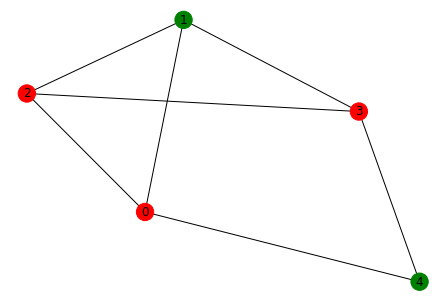

In [3]:
G = nx.convert_matrix.from_numpy_matrix(A) #create a graph from adjacency matrix
pos = nx.spring_layout(G, k = 0.2, iterations = 2000) #define positions for visualization purposes
color_map = [] #define colors based on generator or consumers
for node in G:
    if node in V_gen:
        color_map.append('green')
    else: 
        color_map.append('red') 
nx.draw(G, pos, node_color = color_map, width = 1, with_labels = True) #draw the graph
plt.show()

### Run the simulation

The swing equation is used as a simple power grid model, where generators and consumers are modeled with $N$ rotary machines. This model serves well to approximate the power grid due to the need for synchronization of the AC power supply. defined as
\begin{equation}
\begin{split}
\dot{\theta}_i & = \omega_i \\
I_i\dot{\omega}_i & = P_i - \gamma_i\omega_i + \sum_{j=1}^{N} K_{i,j}\sin(\theta_j - \theta_i),
\end{split}
\end{equation}
where each rotary machine $i$, with $i \in [1, 2, \ldots, N]$, is characterized by its mechanical rotor angle $\theta_i(t)$ and by its angular velocity $\omega_i(t)$ relative to the reference frame of $\Omega = 2\pi(60)$ Hz. $K$ represents the coupling matrix (weighted adjacency matrix), $P$ is the array of power generation and supply of each node, and $\gamma$ is the damping parameter of the dynamics.
We solve for the initial conditions using the steady state solution where $\omega = 0$ and $\theta$ is solved for from
\begin{equation}
 0 = P_i + \sum_{j=1}^{N} K_{i,j}\sin(\theta_j - \theta_i).
\end{equation}
The flow through a line is calculated as
\begin{equation}
F_{i,j}(t) = K_{i,j}\sin(\theta_j(t) - \theta_i(t)).
\end{equation}
If the flow exceeds some capacity limit $\alpha K_{i,j}$ then that line fails, which can then cause other lines to fail as a cascade failure. 


the solution is solved for a steady state and then at 1 second, an edge is cut to understand the resulting dynamics. for the example below this is the edge between vertices 1 and 3.

To solve the equations of motion Newton's method is implemented.

In [4]:
#define the edge that will be cut at 1 second
edge_we_are_cutting = (1,3) #edge between a generator and consumer

Fs, E = PG_network(A, t, V_gen, V_con, K_0, P_gen, P_con, alpha, I_0, damping, e_cut = edge_we_are_cutting) 

### Plot the Results

By plotting the flow through the lines we can see that cutting this line causes a cascade failure, where the flow through a line exceeds the limitations causing for further power surges and further line failures until the entire network fails. 

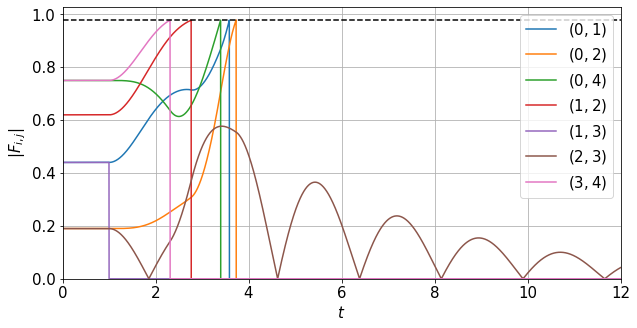

In [5]:
plt.figure(figsize = (10,5))
TextSize = 15
for i in range(len(Fs)):
    plt.plot(t, Fs[i], label = '$('+str(E[i][0])+','+str(E[i][1])+')$')
plt.plot([0,max(t)], [alpha*K_0, alpha*K_0], 'k--')

plt.grid()
plt.xlim(0,max(t))
plt.ylim(0,)
plt.xticks(size = TextSize)
plt.yticks(size = TextSize)
plt.xlabel(r'$t$', size = TextSize)
plt.ylabel(r'$|F_{i,j}|$', size = TextSize)
plt.legend(loc = 'upper right', fontsize = TextSize, ncol = 1)
plt.show()
    